In [22]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scripts.load_data import load_postings, load_votes, get_first_contact_df, subset_users
from tqdm import tqdm

In [23]:
votes = load_votes("input/")
postings = load_postings("input/")

Votes loaded
Postings loaded


-----------------
playing with weighted similarity for channel and resort

In [28]:
#####################################################################################
######the code below completly taken from notebook.ipynb ##################################

import itertools
# one can adapt this with e.g. ressort instead of article

def create_graph(df, article_or_ressort = "ID_Posting", user="UserVote"):
    graph = nx.Graph()
    graph.add_nodes_from(df[article_or_ressort].unique())
    graph.add_nodes_from(df[user].unique())
    graph.add_edges_from(list(map(tuple, df[[article_or_ressort, user]].drop_duplicates().values)))
    graph = graph.to_undirected()
    return graph

def compute_overlap(graph, df, article_or_ressort,verbose=False):
    uu_overlap = {}
    article_ids = df[article_or_ressort].unique()
    for idx, article in enumerate(article_ids):
        if verbose: print(round((idx/len(article_ids))*100), "%", end="\r")
        users_commented =list(graph.neighbors(article))
        for uu_tuple in itertools.product(users_commented, users_commented):
            if uu_tuple[0] != uu_tuple[1]:
                if uu_tuple[0] > uu_tuple[1]:
                    uu_tuple = (uu_tuple[1], uu_tuple[0])
                if uu_tuple in uu_overlap:
                    uu_overlap[uu_tuple] += 1
                else:
                    uu_overlap[uu_tuple] = 1
                    
    return uu_overlap


def user_lookup_df(df, article_or_ressort="ID_Posting", user="UserVote"):
    user_num_articles = df[[user, article_or_ressort]].drop_duplicates()\
        .groupby([user]).size().to_frame()
    # make dict of users and the number of articles they voted on
    user_num_articles = dict(zip(user_num_articles.index, user_num_articles[0]))
    return user_num_articles

def compute_similarity(uu_overlap, user_num_articles, chunckIdx):
    similarities = []
    for uu_tuple in uu_overlap.keys():
        overlap = uu_overlap[uu_tuple]
        try:
            union = user_num_articles[uu_tuple[0]] + user_num_articles[uu_tuple[1]] 
        except:
            print(uu_tuple)
        similarities += [[uu_tuple[0],uu_tuple[1], overlap/union ]]
    return pd.DataFrame(similarities, columns=["A", "B", f"Similarity_{chunckIdx}"]).set_index(["A", "B"])

def compute_time_base_similiarities(selected_postings, article_or_ressort, num_chunks=30):
    sum_sims= 0
    n = 0
    chunks = []
    running_mean = []
    for chunckIdx, subset_df  in enumerate(np.array_split(selected_postings,num_chunks)):
        print(round(chunckIdx/num_chunks) *100, " %", end="\r")
        graph_ressort = create_graph(subset_df, article_or_ressort, "UserCommunityName")
        uu_overlap_ressort = compute_overlap(graph_ressort, subset_df, article_or_ressort)
        user_num_article_or_ressort = user_lookup_df(subset_df, article_or_ressort, "UserCommunityName")
        similarity_table_ressort = compute_similarity(uu_overlap_ressort, user_num_article_or_ressort,chunckIdx)
        n += similarity_table_ressort.shape[0]
        sum_sims += similarity_table_ressort.sum().item()
        chunks += [similarity_table_ressort.mean()]
        running_mean += [sum_sims / n]
    return chunks, running_mean

In [29]:
user_selection = subset_users(votes, postings, "both", num_days_min=30, firt_interaction_middle=True)

selected_postings = postings[postings["UserCommunityName"].isin(user_selection)].sort_values("PostingCreatedAt")
selected_postings["UserCommunityName"] = "user_" + selected_postings["UserCommunityName"]

c:\Users\Ana\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:44: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

c:\Users\Ana\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:44: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

c:\Users\Ana\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:44: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)

0.030942334739803096


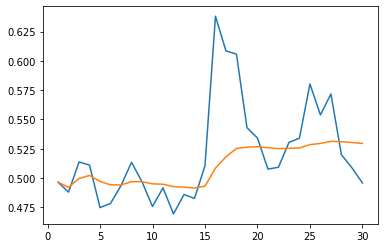

In [30]:
### Similarity based on article topic
time_similarity_channel, time_similarity_running_channel = compute_time_base_similiarities(selected_postings, "ArticleRessortName")
time_similarity_ressort, time_similarity_running_ressort = compute_time_base_similiarities(selected_postings, "ArticleChannel")

postings['ArticleRessortName'].nunique()
postings['ArticleChannel'].nunique()
alfa = (postings['ArticleChannel'].nunique())/(postings['ArticleChannel'].nunique()+postings['ArticleRessortName'].nunique())
print(alfa)
# alfa = 0.3

time_similarity_channel_alfa = [x * alfa for x in time_similarity_channel]
time_similarity_ressort_alfa = [x * (1-alfa) for x in time_similarity_ressort]

time_similarity_running_channel_alfa = [x * alfa for x in time_similarity_running_channel]
time_similarity_running_ressort_alfa = [x * (1-alfa) for x in time_similarity_running_ressort]


time_similarity_final = [x + y for x, y in zip([x * alfa for x in time_similarity_channel], [x * (1-alfa) for x in time_similarity_ressort])]
time_similarity_running_final = [x + y for x, y in zip([x * alfa for x in time_similarity_running_channel], [x * (1-alfa) for x in time_similarity_running_ressort])]

plt.plot(range(1,31), time_similarity_final)
plt.plot(range(1,31), time_similarity_running_final)
import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for alfa in np.arange(0, 1.1, 0.01):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="𝜈 = " + str(alfa),
            x=np.arange(1, 31, 1),
            y = [x + y for x, y in zip([x * alfa for x in time_similarity_running_channel], [x * (1-alfa) for x in time_similarity_running_ressort])]

))

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in np.arange(0, 1.01, 0.01):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to alfa: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][int(i/0.01)] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0.5,
    currentvalue={"prefix": "Alfa: "},
    steps=steps,
    
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

-------------------

## Votes similarity
adjusted functions from notebook.ipynb

In [31]:
merged = pd.merge(votes, postings, on="ID_Posting")
merged["Vote"] = merged["VotePositive"] - merged["VoteNegative"]
merged = merged.rename(columns={"UserCommunityName_x": "UserVote", "UserCommunityName_y": "UserPost"})
merged = merged[merged["UserVote"].isin(user_selection)].sort_values("VoteCreatedAt")
merged = merged[["ID_Posting", "UserPost", "UserVote", "Vote", "VoteCreatedAt"]]
merged.head()

,ID_Posting,UserPost,UserVote,Vote,VoteCreatedAt
69941,1041057893,ottwinner,Weinbergbewohner,1,2019-05-01 08:18:07.060
87584,1041057976,just another random guy,##V+##,1,2019-05-01 08:22:03.587
26040,1041057889,Meiner Ansicht nach,Markus Alexander .,-1,2019-05-01 08:24:48.147
57121,1041058112,Thomas Walach,Jaromir Edler von Eynhuf,1,2019-05-01 08:27:14.250
45765,1041058132,mmmmmmmmmmmmmmmmmmmmmm,DerSchakal1909,1,2019-05-01 08:28:10.450


In [32]:
def compute_overlap_votes(graph_pos, graph_neg, df, article_or_ressort="ID_Posting",verbose=False):
    uu_overlap = {}
    article_ids = df[article_or_ressort].unique()
    for idx, article in enumerate(article_ids):

        try:
            users_voted_pos =list(graph_pos.neighbors(article))
            for uu_tuple in itertools.product(users_voted_pos, users_voted_pos):
                if uu_tuple[0] != uu_tuple[1]:
                    if uu_tuple[0] > uu_tuple[1]:
                        uu_tuple = (uu_tuple[1], uu_tuple[0])
                    if uu_tuple in uu_overlap:
                        uu_overlap[uu_tuple] += 1
                    else:
                        uu_overlap[uu_tuple] = 1
        except:
            users_voted_pos = []

        try:
            users_voted_neg =list(graph_neg.neighbors(article))
            for uu_tuple in itertools.product(users_voted_neg, users_voted_neg):
                if uu_tuple[0] != uu_tuple[1]:
                    if uu_tuple[0] > uu_tuple[1]:
                        uu_tuple = (uu_tuple[1], uu_tuple[0])
                    if uu_tuple in uu_overlap:
                        uu_overlap[uu_tuple] += 1
                    else:
                        uu_overlap[uu_tuple] = 1
        except:
            users_voted_neg = []

        if (len(users_voted_neg) != 0 & len(users_voted_pos) != 0):
            for uu_tuple in itertools.product(users_voted_pos, users_voted_neg):
                if uu_tuple[0] != uu_tuple[1]:
                    if uu_tuple[0] > uu_tuple[1]:
                        uu_tuple = (uu_tuple[1], uu_tuple[0])
                    if uu_tuple in uu_overlap:
                        uu_overlap[uu_tuple] -= 1
                    else:
                        uu_overlap[uu_tuple] = -1
                    
            
    return uu_overlap


def compute_time_base_similiarities_votes(merged, article_or_ressort="ID_Posting", num_chunks=30):
    sum_sims= 0
    n = 0
    chunks = []
    running_mean = []
    for chunckIdx, subset_df  in tqdm(enumerate(np.array_split(merged,num_chunks))):
        print(round(chunckIdx/num_chunks) *100, " %", end="\r")
        positive = subset_df[subset_df["Vote"] == 1]
        negative = subset_df[subset_df["Vote"] == -1]
        graph_pos = create_graph(positive, article_or_ressort, "UserVote")
        graph_neg = create_graph(negative, article_or_ressort, "UserVote")
        uu_overlap_ressort = compute_overlap_votes(graph_pos, graph_neg, subset_df, article_or_ressort)
        user_num_article_or_ressort = user_lookup_df(subset_df, article_or_ressort)
        similarity_table_ressort = compute_similarity(uu_overlap_ressort, user_num_article_or_ressort,chunckIdx)
        n += similarity_table_ressort.shape[0]
        sum_sims += similarity_table_ressort.sum().item()
        chunks += [similarity_table_ressort.mean()]
        running_mean += [sum_sims / n]
    return chunks, running_mean


In [33]:
time_similarity, time_similarity_running = compute_time_base_similiarities_votes(merged, "ID_Posting", 30)

0it [00:00, ?it/s]

1it [00:03,  3.71s/it]

2it [00:07,  3.77s/it]

3it [00:11,  3.76s/it]

4it [00:14,  3.50s/it]

5it [00:16,  3.12s/it]

6it [00:19,  2.93s/it]

7it [00:21,  2.76s/it]

8it [00:24,  2.90s/it]

9it [00:27,  2.73s/it]

10it [00:30,  2.77s/it]

11it [00:32,  2.66s/it]

12it [00:35,  2.58s/it]

13it [00:37,  2.55s/it]

14it [00:41,  2.89s/it]

15it [00:45,  3.18s/it]

16it [00:48,  3.20s/it]

17it [00:51,  3.31s/it]

18it [00:54,  3.15s/it]

19it [00:57,  3.14s/it]

20it [01:00,  2.94s/it]

21it [01:02,  2.74s/it]

22it [01:05,  2.76s/it]

23it [01:07,  2.59s/it]

24it [01:09,  2.48s/it]

25it [01:12,  2.50s/it]

26it [01:14,  2.42s/it]

27it [01:16,  2.40s/it]

28it [01:19,  2.45s/it]

29it [01:21,  2.47s/it]

30it [01:24,  2.83s/it]


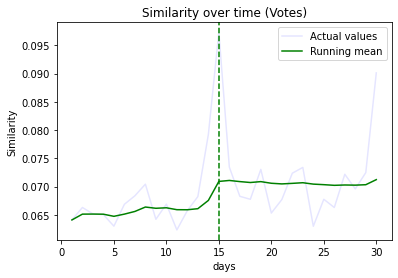

<Figure size 432x288 with 0 Axes>

In [34]:
fig, ax = plt.subplots()

ax.annotate(f'First Contact (replies or votes)', xy=(15, 0.5), xytext=(1, 0.52),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=7))

plt.title(f'Similarity over time (Votes)')
plt.xlabel("days")
plt.ylabel("Similarity")
plt.plot(range(1, 31), time_similarity, alpha=0.1, color="blue")
plt.plot(range(1, 31), time_similarity_running, color="green")
plt.legend(["Actual values", "Running mean"])
plt.axvline(x=15, color="green", linestyle="--")
plt.show()
plt.clf()